# Zebrafish pigmentation

This tutorial uses data from [Saunders, et al (2019)](https://elifesciences.org/articles/45181). Special thanks also go to [Lauren](https://twitter.com/LSaund11) for the tutorial improvement. 

In this [study](https://elifesciences.org/articles/45181), the authors profiled thousands of neural crest-derived cells from trunks of post-embryonic zebrafish. These cell classes include pigment cells, multipotent pigment cell progenitors, peripheral neurons, Schwann cells, chromaffin cells and others. These cells were collected during an active period of post-embryonic development, which has many similarities to fetal and neonatal development in mammals, when many of these cell types are migrating and differentiating as the animal transitions into its adult form. This study also explores the role of thyroid hormone (TH), a common endocrine factor, on the development of these different cell types. 

Such developmental and other dynamical processes are especially suitable for dynamo analysis as dynamo is designed to accurately estimate direction and magnitude of expression dynamics (`RNA velocity`), predict the entire lineage trajectory of any intial cell state (`vector field`), characterize the structure (`vector field topology`) of full gene expression space, as well as fate commitment potential (`single cell potential`). 

Import the package and silence some warning information (mostly `is_categorical_dtype` warning from anndata)

In [1]:
import warnings
warnings.filterwarnings('ignore')

import dynamo as dyn 
from dynamo.configuration import DKM
import numpy as np

this is like R's sessionInfo() which helps you to debug version related bugs if any. 

## Load data

In [2]:
adata = dyn.sample_data.zebrafish()
adata_origin = dyn.sample_data.zebrafish()

|-----> Downloading data to ./data/zebrafish.h5ad
|-----> Downloading data to ./data/zebrafish.h5ad


In [3]:
print(adata.X.min(), adata.X.max(), adata.X.mean())
adata.layers["spliced"] = adata.layers["spliced"].toarray()
temp = adata.layers["spliced"][~np.isnan(adata.layers["spliced"])]
print("unspliced data ")
print(temp.min(), temp.max(), temp.mean(),  temp.std())
adata.layers["unspliced"] = adata.layers["unspliced"].toarray()
temp = adata.layers["unspliced"][~np.isnan(adata.layers["unspliced"])]
print(temp.min(), temp.max(), temp.mean(), temp.std())

0.0 998.0 0.17253423
unspliced data 
0 998 0.17253422253422254 1.9774504673842888
0 2952 0.13544723741827522 6.526400485300376


## Apply pearson residual normalization on different layers according `select_genes_key`. We may use other select_genes function combined with pearson residual normalization.

In [4]:
# adata = dyn.sample_data.zebrafish()
from dynamo.preprocessing import Preprocessor
import pearson_residual_normalization_recipe
monocle_filter_genes_by_outliers_kwargs = Preprocessor.get_monocle_filter_genes_outliers_kwargs(adata)
preprocessor = Preprocessor(filter_genes_by_outliers_kwargs=monocle_filter_genes_by_outliers_kwargs)
preprocessor.preprocess_adata(adata)


|-----> Running preprocessing pipeline...
|-----------> <insert> {} to uns['pp'] in AnnData Object.
|-----------> <insert> tkey=None to uns['pp'] in AnnData Object.
|-----------> <insert> experiment_type=None to uns['pp'] in AnnData Object.
|-----> making adata observation index unique...
|-----> applying collapse species adata...
|-----> applying convert_gene_name function...
|-----> filtering outlier cells...
|-----------> filtering cells by layer:X
|-----------> filtering cells by layer:spliced
|-----------> filtering cells by layer:unspliced
|-----> skip filtering by layer:protein as it is not in adata.
|-----> <insert> pass_basic_filter to obs in AnnData Object.
|-----------> inplace subsetting adata by filtered genes
|-----> filtering outlier genes...
|-----> extra kwargs:{'filter_bool': None, 'layer': 'all', 'min_cell_s': 41.81, 'min_cell_u': 20.905, 'min_cell_p': 20.905, 'min_avg_exp_s': 0, 'min_avg_exp_u': 0, 'min_avg_exp_p': 0, 'max_avg_exp': inf, 'min_count_s': 0, 'min_count

In [5]:
adata

AnnData object with n_obs × n_vars = 4167 × 16940
    obs: 'split_id', 'sample', 'Size_Factor', 'condition', 'Cluster', 'Cell_type', 'umap_1', 'umap_2', 'batch', 'pass_basic_filter', 'unspliced_Size_Factor', 'initial_unspliced_cell_size', 'spliced_Size_Factor', 'initial_spliced_cell_size'
    var: 'pass_basic_filter', 'pp_gene_means', 'gene_vars', 'gene_highly_variable', 'use_for_pca', 'gene_highly_variable_scores'
    uns: 'pp'
    layers: 'spliced', 'unspliced', 'X_unspliced', 'X_spliced'

|-----> retrive data for non-linear dimension reduction...
|-----> perform umap...
|-----> [dimension_reduction projection] in progress: 100.0000%
|-----> [dimension_reduction projection] finished [30.5331s]


<Figure size 1200x1200 with 0 Axes>

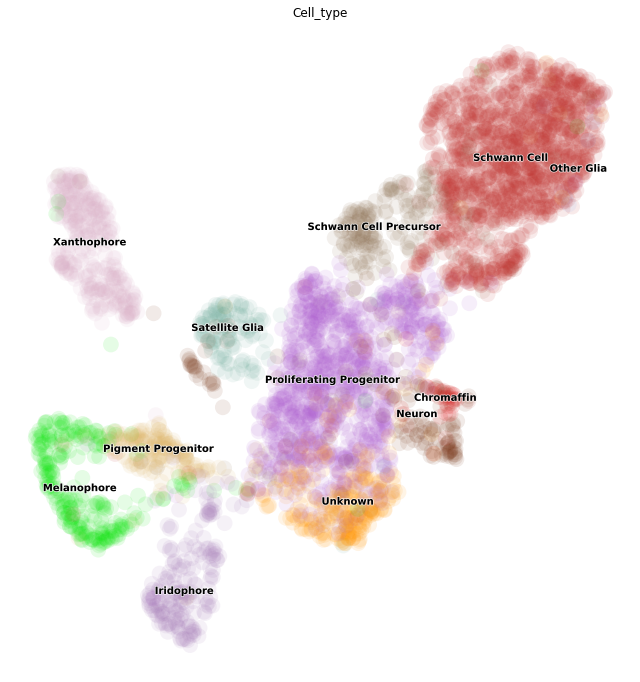

In [6]:
dyn.tl.reduceDimension(adata,basis="pca")
dyn.pl.umap(adata, color="Cell_type", figsize=(12, 12))

In [7]:
adata

AnnData object with n_obs × n_vars = 4167 × 16940
    obs: 'split_id', 'sample', 'Size_Factor', 'condition', 'Cluster', 'Cell_type', 'umap_1', 'umap_2', 'batch', 'pass_basic_filter', 'unspliced_Size_Factor', 'initial_unspliced_cell_size', 'spliced_Size_Factor', 'initial_spliced_cell_size'
    var: 'pass_basic_filter', 'pp_gene_means', 'gene_vars', 'gene_highly_variable', 'use_for_pca', 'gene_highly_variable_scores'
    uns: 'pp', 'PCs', 'explained_variance_ratio_', 'pca_mean', 'pca_valid_ind', 'neighbors', 'umap_fit', 'Cell_type_colors'
    obsm: 'X_pca', 'X_umap'
    layers: 'spliced', 'unspliced', 'X_unspliced', 'X_spliced'

In [8]:
dyn.tl.dynamics(adata, model='stochastic', cores=3) 

|-----> dynamics_del_2nd_moments_key is None. Using default value from DynamoAdataConfig: dynamics_del_2nd_moments_key=False
|-----> calculating first/second moments...
|-----> [moments calculation] in progress: 100.0000%
|-----> [moments calculation] finished [18.6224s]


AnnData object with n_obs × n_vars = 4167 × 16940
    obs: 'split_id', 'sample', 'Size_Factor', 'condition', 'Cluster', 'Cell_type', 'umap_1', 'umap_2', 'batch', 'pass_basic_filter', 'unspliced_Size_Factor', 'initial_unspliced_cell_size', 'spliced_Size_Factor', 'initial_spliced_cell_size'
    var: 'pass_basic_filter', 'pp_gene_means', 'gene_vars', 'gene_highly_variable', 'use_for_pca', 'gene_highly_variable_scores', 'beta', 'gamma', 'half_life', 'alpha_b', 'alpha_r2', 'gamma_b', 'gamma_r2', 'gamma_logLL', 'delta_b', 'delta_r2', 'bs', 'bf', 'uu0', 'ul0', 'su0', 'sl0', 'U0', 'S0', 'total0', 'use_for_dynamics'
    uns: 'pp', 'PCs', 'explained_variance_ratio_', 'pca_mean', 'pca_valid_ind', 'neighbors', 'umap_fit', 'Cell_type_colors', 'dynamics'
    obsm: 'X_pca', 'X_umap', 'X'
    layers: 'spliced', 'unspliced', 'X_unspliced', 'X_spliced', 'M_u', 'M_uu', 'M_s', 'M_us', 'M_ss', 'velocity_S'
    obsp: 'moments_con'

<Figure size 1200x1200 with 0 Axes>

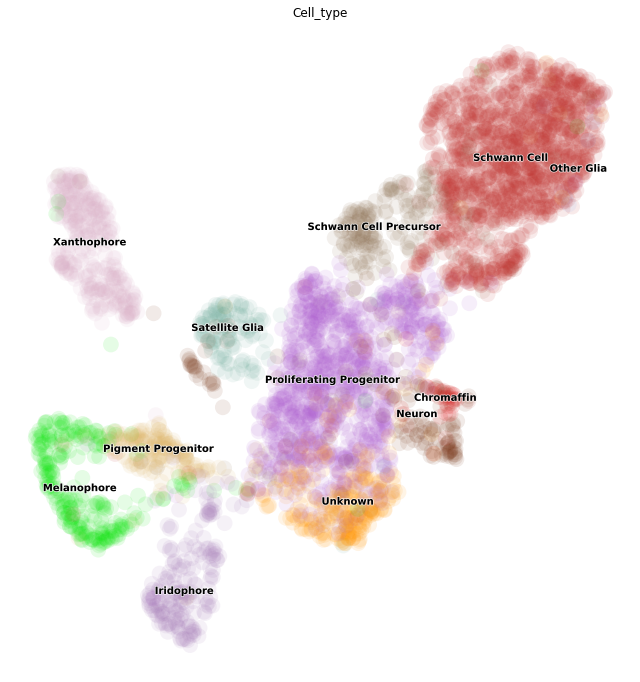

In [9]:
dyn.pl.umap(adata, color="Cell_type", figsize=(12, 12))

|-----> retrive data for non-linear dimension reduction...
|-----? adata already have basis umap. dimension reduction umap will be skipped! 
set enforce=True to re-performing dimension reduction.
|-----> Start computing neighbor graph...
|-----------> X_data is None, fetching or recomputing...
|-----> fetching X data from layer:None, basis:pca
|-----> method arg is None, choosing methods automatically...
|-----------> method ball_tree selected


layer: X  basis: umap


|-----> <insert> connectivities to obsp in AnnData Object.
|-----> <insert> distances to obsp in AnnData Object.
|-----> <insert> neighbors to uns in AnnData Object.
|-----> <insert> neighbors.indices to uns in AnnData Object.
|-----> <insert> neighbors.params to uns in AnnData Object.
|-----> [dimension_reduction projection] in progress: 100.0000%
|-----> [dimension_reduction projection] finished [0.4178s]
|-----> 0 genes are removed because of nan velocity values.
|-----> [calculating transition matrix via pearson kernel with sqrt transform.] in progress: 100.0000%
|-----> [calculating transition matrix via pearson kernel with sqrt transform.] finished [5.0182s]
|-----> [projecting velocity vector to low dimensional embedding] in progress: 100.0000%
|-----> [projecting velocity vector to low dimensional embedding] finished [0.9395s]


<Figure size 600x400 with 0 Axes>

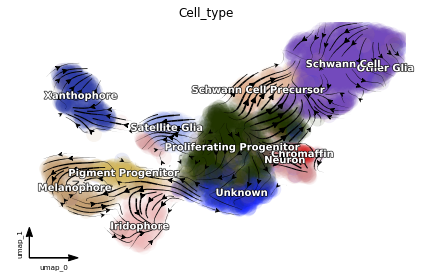

In [10]:
dyn.pl.streamline_plot(adata, color=['Cell_type'], basis='umap', show_legend='on data', show_arrowed_spines=True);


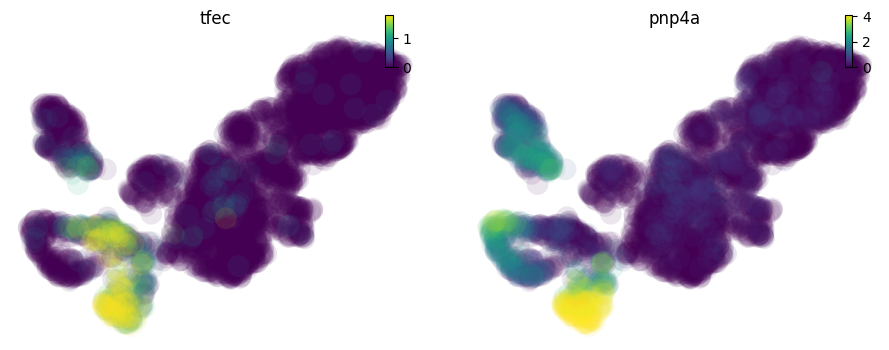

In [11]:
dyn.pl.umap(adata, color=['tfec', 'pnp4a'])

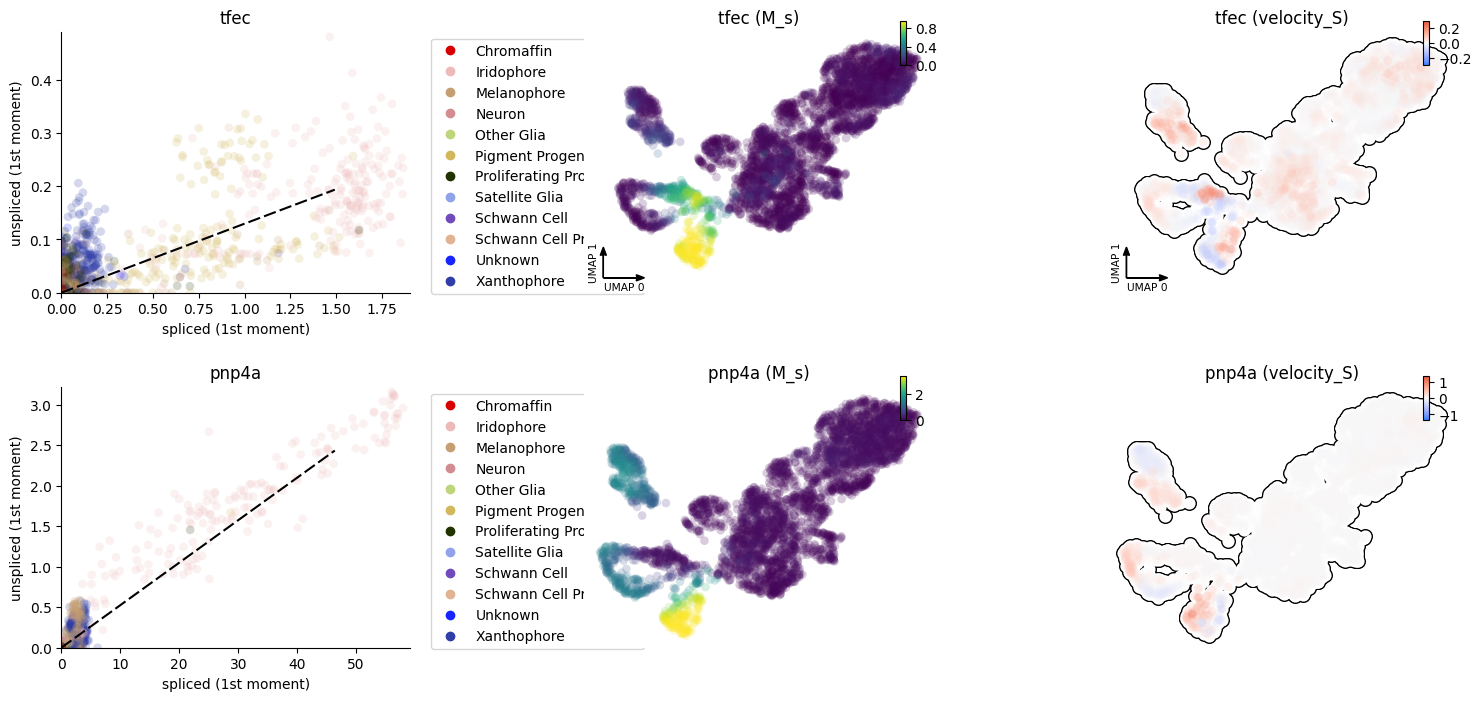

In [12]:
dyn.pl.phase_portraits(adata, genes=['tfec', 'pnp4a'],  figsize=(6, 4), color='Cell_type')

In [13]:
adata.layers["spliced"]

array([[  1,   1,   1, ...,   0,   0,   0],
       [  2,   2,   0, ...,   0,   0,   0],
       [  5,   1,   2, ...,   0,   0,   0],
       ...,
       [121,  44,  81, ...,   0,   0,   0],
       [139,  63,  82, ...,   0,   0,   0],
       [ 66,  39,  41, ...,   0,   0,   0]], dtype=int64)

In [14]:
print(adata.X.min(), adata.X.max(), adata.X.mean(),  temp.std())
temp = adata.layers["spliced"][~np.isnan(adata.layers["spliced"])]
print(temp.min(), temp.max(), temp.mean(),  temp.std())
temp = adata.layers["unspliced"][~np.isnan(adata.layers["unspliced"])]
print(temp.min(), temp.max(), temp.mean(), temp.std())

0.0 6.906755 0.060049318 6.526400485300376
0 998 0.17308550144795973 1.9807203202302495
0 2952 0.13589286883023385 6.5373410089535415


In [15]:
adata.uns["pp"]

{'tkey': None,
 'has_splicing': True,
 'has_labeling': False,
 'has_protein': False,
 'splicing_labeling': False,
 'experiment_type': 'conventional',
 'norm_method': None}